# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                 
Sample_013  A6NLU5                            17.870
Sample_152  F2Z2C8;Q9BVH7                     12.313
Sample_063  J3KQG3;Q5JZY3;Q5JZY3-2;Q5JZY3-3   16.662
Sample_153  Q9UQM7                            16.604
Sample_018  G3V2W1;Q9UK55                     14.040
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups 
Sample_026  P02792            14.829
Sample_055  O15204;O15204-2   14.315
Sample_119  Q13867            13.776
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.933
            A0A075B6Q5                 14.296
            A0A075B6R2                 13.452
            A0A075B6S5                 13.595
            A0A087WSY4                 12.801
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.111
            Q9UI40;Q9UI40-2            11.289
            Q9UIW2                     12.637
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.821
            Q9UP79                     11.975
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.116,15.050,16.842,19.863,14.049,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.018,19.067,...,15.528,15.576,11.958,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.029,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.873,17.705,17.039,13.886,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,13.726,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.735,15.345,17.084,18.708,14.249,19.433,8.295,10.240
Sample_207,15.739,16.877,15.469,16.898,9.541,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.741,12.732,14.096,13.696,13.216,12.783,13.368,12.697,11.936,12.748
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.068,19.067,16.127,...,13.270,13.948,13.609,14.201,12.929,11.366,12.673,12.846,12.571,11.777
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.962,12.900,12.702,12.216,12.626,12.731,11.033,13.288,12.080,12.871
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.635,12.876,13.018,12.608,12.281,14.064,13.744,13.191,12.732,14.140
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.372,13.177,13.543,13.324,13.361,11.527,11.807,12.224,14.079,13.110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.342,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 100.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.94it/s]

100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.47it/s]

100%|██████████| 4/4 [00:00<00:00,  3.97it/s]

100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.07it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.99it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.75it/s]

100%|██████████| 5/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.77it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.45it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.64it/s]

100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.52it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.34it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.01it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.16it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.42it/s]

100%|██████████| 7/7 [00:02<00:00,  3.58it/s]

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.00it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.11it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.93it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.80it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.75it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  4.01it/s]

100%|██████████| 8/8 [00:02<00:00,  4.00it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.14it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.16it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.50it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.48it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.62it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.50it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.42it/s]

100%|██████████| 9/9 [00:01<00:00,  4.44it/s]

100%|██████████| 9/9 [00:01<00:00,  4.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.93it/s]

 30%|███       | 3/10 [00:00<00:01,  5.25it/s]

 40%|████      | 4/10 [00:00<00:01,  4.98it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.63it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.56it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.19it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  3.40it/s]

100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.67it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.38it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.04it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.84it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.46it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.42it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.19it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.12it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.18it/s]

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

100%|██████████| 11/11 [00:03<00:00,  3.60it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.06it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.43it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.01it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.26it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.11it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.24it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.34it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.40it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.39it/s]

100%|██████████| 12/12 [00:03<00:00,  3.07it/s]

100%|██████████| 12/12 [00:03<00:00,  3.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.06it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.63it/s]

 31%|███       | 4/13 [00:00<00:02,  3.82it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.55it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.33it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.40it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.44it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.51it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.59it/s]

100%|██████████| 13/13 [00:03<00:00,  3.52it/s]

100%|██████████| 13/13 [00:03<00:00,  3.65it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.86it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.27it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.70it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.46it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.26it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.34it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.35it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.55it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.50it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.64it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.65it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.65it/s]

100%|██████████| 14/14 [00:03<00:00,  3.31it/s]

100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.56it/s]

 20%|██        | 3/15 [00:00<00:02,  4.96it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.88it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.31it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.27it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.23it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.34it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.36it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.32it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.51it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.12it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.89it/s]

100%|██████████| 15/15 [00:04<00:00,  2.85it/s]

100%|██████████| 15/15 [00:04<00:00,  3.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.033 0.003          0.790 0.319       0.127   
2             0.004 0.003      0.050 0.021          0.615 0.145       0.476   
3             0.006 0.006      0.059 0.027          0.823 0.078       0.724   
4             0.004 0.006      0.041 0.014          0.813 0.081       0.771   
5             0.004 0.004      0.050 0.024          0.826 0.087       0.791   
6             0.004 0.003      0.041 0.018          0.827 0.087       0.781   
7             0.003 0.000      0.038 0.010          0.827 0.077       0.800   
8             0.005 0.004      0.056 0.023          0.838 0.083       0.800   
9             0.006 0.006      0.067 0.022          0.831 0.084       0.830   
10            0.008 0.006      0.063 0.020          0.819 0.082       0.830   
11            0.006 0.005      0.052 0.025          0.810 0.084       0.810   
12            0.004 0.003      0.047 0.022          0.812 0.082       0.810   
13            0.005 0.004      0.058 0.028          0.819 0.086       0.801   
14            0.006 0.005      0.052 0.021          0.823 0.083       0.795   
15            0.005 0.004      0.053 0.023          0.821 0.080       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.211 0.129                  0.556 0.042        0.857   
2          0.121   0.525 0.102                  0.622 0.072        0.706   
3          0.097   0.765 0.064                  0.803 0.051        0.903   
4          0.100   0.785 0.064                  0.818 0.053        0.906   
5          0.094   0.803 0.066                  0.832 0.056        0.912   
6          0.097   0.798 0.068                  0.828 0.057        0.911   
7          0.076   0.810 0.053                  0.837 0.046        0.911   
8          0.087   0.815 0.067                  0.842 0.057        0.911   
9          0.084   0.827 0.064                  0.851 0.056        0.925   
10         0.093   0.820 0.067                  0.846 0.058        0.925   
11         0.094   0.806 0.072                  0.834 0.062        0.923   
12         0.097   0.807 0.069                  0.835 0.060        0.922   
13         0.104   0.805 0.075                  0.834 0.063        0.926   
14         0.097   0.804 0.068                  0.833 0.057        0.925   
15         0.102   0.803 0.071                  0.833 0.059        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.824 0.083        210.000 0.000  
2          0.083                  0.651 0.100        210.000 0.000  
3          0.043                  0.876 0.056        210.000 0.000  
4          0.042                  0.881 0.052        210.000 0.000  
5          0.043                  0.890 0.053        210.000 0.000  
6          0.045                  0.889 0.055        210.000 0.000  
7          0.045                  0.889 0.056        210.000 0.000  
8          0.044                  0.891 0.053        210.000 0.000  
9          0.040                  0.912 0.046        210.000 0.000  
10         0.041                  0.913 0.046        210.000 0.000  
11         0.042                  0.911 0.047        210.000 0.000  
12         0.043                  0.907 0.049        210.000 0.000  
13         0.043                  0.915 0.047        210.000 0.000  
14         0.043                  0.914 0.047        210.000 0.000  
15         0.043                  0.912 0.048 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 485.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.64it/s]

100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.70it/s]

100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

100%|██████████| 4/4 [00:00<00:00,  4.43it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.30it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.16it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.29it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.45it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.58it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

100%|██████████| 6/6 [00:01<00:00,  3.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.16it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.05it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.19it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.53it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.57it/s]

100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.03it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.34it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.77it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.89it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.70it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.50it/s]

100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.06it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.14it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.26it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.04it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.76it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.90it/s]

 30%|███       | 3/10 [00:00<00:01,  3.73it/s]

 40%|████      | 4/10 [00:01<00:01,  3.15it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.92it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.27it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.02it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.82it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.05it/s]

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]

100%|██████████| 10/10 [00:03<00:00,  3.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.29it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.00it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.94it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.73it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.84it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.26it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.65it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.33it/s]

100%|██████████| 11/11 [00:03<00:00,  2.35it/s]

100%|██████████| 11/11 [00:03<00:00,  3.05it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.90it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.19it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.91it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.08it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.03it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.05it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.03it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.75it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.00it/s]

100%|██████████| 12/12 [00:03<00:00,  3.08it/s]

100%|██████████| 12/12 [00:03<00:00,  3.07it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.28it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.91it/s]

 31%|███       | 4/13 [00:00<00:02,  4.35it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.15it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.65it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.29it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.11it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.15it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.84it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.59it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.47it/s]

100%|██████████| 13/13 [00:04<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  3.10it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.92it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.29it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.93it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.97it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.94it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.75it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.87it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.68it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.44it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.31it/s]

100%|██████████| 14/14 [00:05<00:00,  2.31it/s]

100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.55it/s]

 20%|██        | 3/15 [00:00<00:03,  3.58it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.20it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.30it/s]

 40%|████      | 6/15 [00:01<00:03,  2.88it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.80it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.73it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.79it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.92it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.06it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.11it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.12it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.22it/s]

100%|██████████| 15/15 [00:04<00:00,  3.25it/s]

100%|██████████| 15/15 [00:04<00:00,  3.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.044 0.012          0.794 0.317       0.136   
2             0.004 0.003      0.046 0.017          0.627 0.118       0.539   
3             0.005 0.005      0.055 0.021          0.775 0.077       0.731   
4             0.005 0.004      0.051 0.018          0.776 0.075       0.781   
5             0.007 0.006      0.052 0.024          0.759 0.085       0.744   
6             0.004 0.003      0.039 0.010          0.786 0.090       0.770   
7             0.003 0.002      0.035 0.008          0.806 0.099       0.764   
8             0.004 0.002      0.039 0.012          0.806 0.101       0.770   
9             0.005 0.004      0.048 0.018          0.796 0.107       0.758   
10            0.004 0.003      0.039 0.009          0.777 0.106       0.774   
11            0.004 0.002      0.040 0.011          0.838 0.082       0.823   
12            0.005 0.004      0.051 0.021          0.842 0.083       0.825   
13            0.004 0.001      0.042 0.014          0.839 0.083       0.813   
14            0.007 0.008      0.067 0.027          0.833 0.080       0.815   
15            0.006 0.007      0.054 0.022          0.819 0.092       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.224 0.133                  0.560 0.044        0.850   
2          0.122   0.573 0.103                  0.650 0.073        0.736   
3          0.101   0.748 0.072                  0.787 0.057        0.860   
4          0.109   0.773 0.070                  0.807 0.057        0.871   
5          0.108   0.746 0.073                  0.784 0.059        0.869   
6          0.099   0.772 0.062                  0.805 0.052        0.874   
7          0.105   0.779 0.077                  0.812 0.062        0.898   
8          0.099   0.782 0.073                  0.814 0.059        0.896   
9          0.112   0.770 0.083                  0.805 0.067        0.897   
10         0.114   0.768 0.081                  0.802 0.067        0.902   
11         0.102   0.825 0.068                  0.852 0.057        0.918   
12         0.104   0.829 0.070                  0.854 0.059        0.918   
13         0.107   0.822 0.078                  0.849 0.064        0.917   
14         0.108   0.819 0.074                  0.847 0.061        0.915   
15         0.107   0.805 0.073                  0.834 0.061        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.074                  0.681 0.090        210.000 0.000  
3          0.054                  0.841 0.061        210.000 0.000  
4          0.053                  0.855 0.056        210.000 0.000  
5          0.053                  0.848 0.059        210.000 0.000  
6          0.053                  0.859 0.062        210.000 0.000  
7          0.051                  0.876 0.063        210.000 0.000  
8          0.051                  0.875 0.065        210.000 0.000  
9          0.053                  0.878 0.062        210.000 0.000  
10         0.052                  0.880 0.061        210.000 0.000  
11         0.050                  0.907 0.051        210.000 0.000  
12         0.050                  0.908 0.051        210.000 0.000  
13         0.051                  0.907 0.053        210.000 0.000  
14         0.051                  0.905 0.052        210.000 0.000  
15         0.050                  0.906 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1160.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 23.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.56it/s]

100%|██████████| 3/3 [00:00<00:00, 22.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 27.60it/s]

100%|██████████| 4/4 [00:00<00:00, 21.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.15it/s]

100%|██████████| 5/5 [00:00<00:00, 16.12it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.13it/s]

100%|██████████| 6/6 [00:00<00:00, 16.55it/s]

100%|██████████| 6/6 [00:00<00:00, 17.04it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.92it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 17.41it/s]

100%|██████████| 7/7 [00:00<00:00, 15.00it/s]

100%|██████████| 7/7 [00:00<00:00, 15.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 27.29it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.68it/s]

100%|██████████| 8/8 [00:00<00:00, 18.82it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.94it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.09it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.58it/s]

100%|██████████| 9/9 [00:00<00:00, 16.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 22.65it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.24it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.81it/s]

100%|██████████| 10/10 [00:00<00:00, 15.45it/s]

100%|██████████| 10/10 [00:00<00:00, 16.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.43it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.91it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.71it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.14it/s]

100%|██████████| 11/11 [00:00<00:00, 14.53it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 27.43it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.81it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.63it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.52it/s]

100%|██████████| 12/12 [00:00<00:00, 15.69it/s]

100%|██████████| 12/12 [00:00<00:00, 16.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 24.02it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.96it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.84it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.08it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.95it/s]

100%|██████████| 13/13 [00:00<00:00, 15.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.64it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.68it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.16it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.32it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 16.03it/s]

100%|██████████| 14/14 [00:00<00:00, 15.87it/s]

100%|██████████| 14/14 [00:00<00:00, 16.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.35it/s]

 33%|███▎      | 5/15 [00:00<00:00, 16.04it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.06it/s]

 60%|██████    | 9/15 [00:00<00:00, 15.08it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.84it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 13.99it/s]

100%|██████████| 15/15 [00:01<00:00, 14.36it/s]

100%|██████████| 15/15 [00:01<00:00, 14.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.003      0.033 0.008          0.000 0.000       0.000   
2             0.004 0.003      0.041 0.014          0.489 0.207       0.154   
3             0.003 0.001      0.028 0.008          0.482 0.140       0.221   
4             0.004 0.004      0.045 0.015          0.494 0.138       0.234   
5             0.003 0.000      0.036 0.010          0.512 0.134       0.258   
6             0.004 0.003      0.043 0.016          0.550 0.111       0.387   
7             0.004 0.002      0.036 0.006          0.532 0.121       0.392   
8             0.004 0.003      0.042 0.015          0.539 0.085       0.425   
9             0.004 0.003      0.042 0.012          0.547 0.089       0.457   
10            0.004 0.003      0.045 0.016          0.534 0.095       0.430   
11            0.005 0.003      0.041 0.011          0.515 0.099       0.447   
12            0.005 0.003      0.047 0.017          0.530 0.098       0.472   
13            0.005 0.003      0.047 0.017          0.579 0.104       0.512   
14            0.005 0.004      0.043 0.014          0.568 0.089       0.501   
15            0.004 0.000      0.039 0.010          0.564 0.093       0.508   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.723   
2          0.074   0.225 0.097                  0.514 0.047        0.639   
3          0.099   0.295 0.105                  0.525 0.049        0.623   
4          0.107   0.307 0.109                  0.530 0.052        0.612   
5          0.097   0.333 0.100                  0.537 0.052        0.612   
6          0.093   0.446 0.081                  0.572 0.058        0.632   
7          0.108   0.440 0.088                  0.563 0.061        0.633   
8          0.111   0.467 0.087                  0.579 0.051        0.651   
9          0.099   0.491 0.079                  0.588 0.054        0.646   
10         0.103   0.469 0.083                  0.576 0.054        0.640   
11         0.109   0.472 0.089                  0.568 0.065        0.633   
12         0.119   0.491 0.092                  0.580 0.068        0.632   
13         0.115   0.536 0.091                  0.617 0.065        0.677   
14         0.115   0.525 0.086                  0.610 0.060        0.673   
15         0.115   0.527 0.089                  0.608 0.063        0.668   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.647 0.078        210.000 0.000  
2          0.093                  0.556 0.092        210.000 0.000  
3          0.073                  0.550 0.072        210.000 0.000  
4          0.076                  0.542 0.074        210.000 0.000  
5          0.068                  0.541 0.072        210.000 0.000  
6          0.062                  0.551 0.079        210.000 0.000  
7          0.068                  0.562 0.085        210.000 0.000  
8          0.067                  0.566 0.078        210.000 0.000  
9          0.066                  0.571 0.077        210.000 0.000  
10         0.070                  0.566 0.081        210.000 0.000  
11         0.072                  0.570 0.080        210.000 0.000  
12         0.072                  0.560 0.082        210.000 0.000  
13         0.071                  0.614 0.083        210.000 0.000  
14         0.072                  0.616 0.084        210.000 0.000  
15         0.070                  0.613 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,14,14
score_time,9,14,13
test_precision,8,12,13
test_recall,10,12,13
test_f1,9,12,13
test_balanced_accuracy,9,12,13
test_roc_auc,13,12,1
test_average_precision,13,12,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.11it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.38it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.86it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.20it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.11it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.96it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.01it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.27it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  2.94it/s]

100%|██████████| 12/12 [00:03<00:00,  2.76it/s]

100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1104.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.77it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.52it/s]

 31%|███       | 4/13 [00:00<00:01,  5.01it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.90it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.76it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.70it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.41it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.54it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.52it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.34it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.01it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

100%|██████████| 13/13 [00:03<00:00,  4.33it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


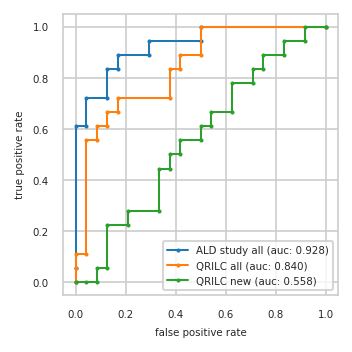

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.611     0.000 0.111     0.083 0.000
3          0.042 0.611     0.042 0.111     0.083 0.056
4          0.042 0.722     0.042 0.556     0.125 0.056
5          0.125 0.722     0.083 0.556     0.125 0.222
6          0.125 0.833     0.083 0.611     0.208 0.222
7          0.167 0.833     0.125 0.611     0.208 0.278
8          0.167 0.889     0.125 0.667     0.333 0.278
9          0.292 0.889     0.167 0.667     0.333 0.444
10         0.292 0.944     0.167 0.722     0.375 0.444
11         0.500 0.944     0.375 0.722     0.375 0.500
12         0.500 1.000     0.375 0.833     0.417 0.500
13         1.000 1.000     0.417 0.833     0.417 0.556
14           NaN   NaN     0.417 0.889     0.500 0.556
15           NaN   NaN     0.500 0.889     0.500 0.611
16           NaN   NaN     0.500 1.000     0.542 0.611
17           NaN   NaN     1.000 1.000     0.542 0.667
18           NaN   NaN       NaN   NaN     0.625 0.667
19           NaN   NaN       NaN   NaN     0.625 0.778
20           NaN   NaN       NaN   NaN     0.708 0.778
21           NaN   NaN       NaN   NaN     0.708 0.833
22           NaN   NaN       NaN   NaN     0.750 0.833
23           NaN   NaN       NaN   NaN     0.750 0.889
24           NaN   NaN       NaN   NaN     0.833 0.889
25           NaN   NaN       NaN   NaN     0.833 0.944
26           NaN   NaN       NaN   NaN     0.917 0.944
27           NaN   NaN       NaN   NaN     0.917 1.000
28           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
1,K7ER15;Q9H0R4;Q9H0R4-2,P60709;P63261,None
2,P02741,P04430,None
3,P61981,P10636-2;P10636-6,None
4,P04075,P61981,None
5,P14174,P04075,None
6,E7EUF1;Q13822-3,P14174,None
7,P00338;P00338-3,P08294,None
8,P14618,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


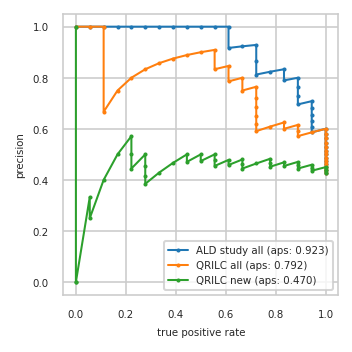

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.571 0.889     0.464 0.722
15         0.630 0.944     0.593 0.889     0.444 0.667
16         0.654 0.944     0.615 0.889     0.462 0.667
17         0.680 0.944     0.600 0.833     0.480 0.667
18         0.708 0.944     0.625 0.833     0.458 0.611
19         0.696 0.889     0.609 0.778     0.478 0.611
20         0.727 0.889     0.591 0.722     0.455 0.556
21         0.762 0.889     0.619 0.722     0.476 0.556
22         0.800 0.889     0.650 0.722     0.500 0.556
23         0.789 0.833     0.684 0.722     0.474 0.500
24         0.833 0.833     0.722 0.722     0.500 0.500
25         0.824 0.778     0.765 0.722     0.471 0.444
26         0.812 0.722     0.750 0.667     0.500 0.444
27         0.867 0.722     0.800 0.667     0.467 0.389
28         0.929 0.722     0.786 0.611     0.429 0.333
29         0.923 0.667     0.846 0.611     0.385 0.278
30         0.917 0.611     0.833 0.556     0.417 0.278
31         1.000 0.611     0.909 0.556     0.455 0.278
32         1.000 0.556     0.900 0.500     0.500 0.278
33         1.000 0.500     0.889 0.444     0.444 0.222
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.250 0.056
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


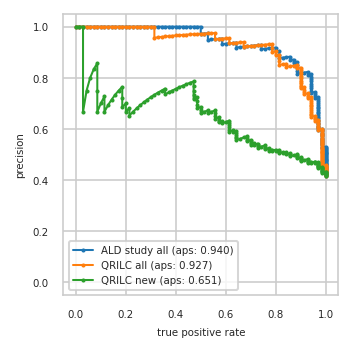

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


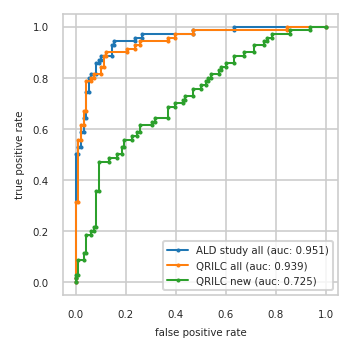

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}